In [52]:
!pip install surprise


In [0]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import preprocessing
from surprise import SVD
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import accuracy
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [0]:
import os
import numpy as np
import pandas as pd
%matplotlib inline
import pandas
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn.externals import joblib
import joblib

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
ratings_data = pd.read_csv("/content/drive/My Drive/24nov/ratings_Electronics.csv")

In [57]:
ratings_data.head()

,AKM1MP6P0OYPR,0132793040,5.0,1365811200
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [0]:
ratings_data.columns = ['userid', 'productId', 'ratings', 'timestamp']

In [59]:
ratings_data.head()

,userid,productId,ratings,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [60]:
ratings_data.shape

(7824481, 4)

In [61]:
print('#ratings %d' % len(ratings_data.index))

#ratings 7824481


In [62]:
print('total unique users %d' % len(ratings_data['userid'].unique()))

total unique users 4201696


In [63]:
# 5 point summary of ratings
print('min: %.1f' % np.min(ratings_data.ratings))
print('25 percentile: %.1f' % np.percentile(ratings_data.ratings, 25))
print('median: %.1f' % np.median(ratings_data['ratings']))
print('75 percentile: %.1f' % np.percentile(ratings_data.ratings, 75))
print('max: %.1f' % np.max(ratings_data.ratings))

min: 1.0
25 percentile: 3.0
median: 5.0
75 percentile: 5.0
max: 5.0


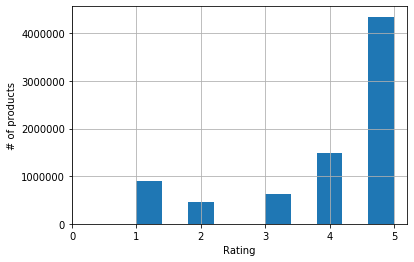

In [64]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(ratings_data.ratings)
plt.xticks([0, 1.0, 2.0, 3.0, 4.0, 5.0])
plt.xlabel('Rating')
plt.ylabel('# of products')
plt.grid()
plt.show()

In [65]:
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
userid       object
productId    object
ratings      float64
timestamp    int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [66]:
ratings_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ratings,7824481.0,4.012337e+00,1.380910e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,7824481.0,1.338178e+09,6.900426e+07,912729600.0,1.315354e+09,1.361059e+09,1.386115e+09,1.406074e+09


In [67]:
ratings_data.isnull().values.any()

False

In [0]:
ratings_data = ratings_data.drop('timestamp',axis=1)

In [69]:
# Users with max no of purchases
ratings_data["userid"].value_counts().head()

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: userid, dtype: int64

In [70]:
ratings_data.groupby('productId')['ratings'].mean().head()

productId
0321732944    5.000000
0439886341    1.666667
0511189877    4.500000
0528881469    2.851852
0558835155    3.000000
Name: ratings, dtype: float64

In [71]:
ratings_data.groupby('productId')['ratings'].mean().sort_values(ascending=False).head()

productId
BT008V9J9U    5.0
B0058PRC0S    5.0
B0058ORBFU    5.0
B0058OQ9Q2    5.0
B0058OKSMS    5.0
Name: ratings, dtype: float64

In [72]:
ratings_data.groupby('productId')['ratings'].count().sort_values(ascending=False).head()

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: ratings, dtype: int64

In [0]:
#Build Popularity Recommender model.
ratings_mean_count = pd.DataFrame(ratings_data.groupby('productId')['ratings'].mean())


In [74]:
ratings_mean_count

,ratings
productId,
0321732944,5.000000
0439886341,1.666667
0511189877,4.500000
0528881469,2.851852
0558835155,3.000000
...,...
BT008G3W52,5.000000
BT008SXQ4C,1.000000
BT008T2BGK,5.000000


In [75]:
ratings_data

,userid,productId,ratings
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0
...,...,...,...
7824476,A2YZI3C9MOHC0L,BT008UKTMW,5.0
7824477,A322MDK0M89RHN,BT008UKTMW,5.0
7824478,A1MH90R0ADMIK0,BT008UKTMW,4.0
7824479,A10M2KEFPEQDHN,BT008UKTMW,4.0


In [76]:
#Making Data Sparser
user_counts= ratings_data['userid'].value_counts()
user_counts.head()

A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
Name: userid, dtype: int64

In [77]:
ratings_data.shape

(7824481, 3)

In [78]:
ratings_new=ratings_data[ratings_data['userid'].isin(user_counts[user_counts >=50].index)]
ratings_new.head()

,userid,productId,ratings
93,A3BY5KCNQZXV5U,0594451647,5.0
117,AT09WGFUM934H,0594481813,3.0
176,A32HSNCNPRUMTR,0970407998,1.0
177,A17HMM1M7T9PJ1,0970407998,4.0
491,A3CLWR1UUZT6TG,0972683275,5.0


In [79]:
ratings_new.shape

(125871, 3)

In [80]:
ratings_new1 = ratings_new.sample(frac=0.1, random_state=1)
ratings_new1.shape

(12587, 3)

In [81]:
from surprise import KNNWithMeans
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Dataset,Reader
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_new1[['userid', 'productId', 'ratings']], reader)
data

In [0]:
# Split data to train and test
from surprise.model_selection import train_test_split
trainset, testset = train_test_split(data, test_size=.30,random_state=123)

In [83]:
# Build Collaborative Filtering model.
user_records = trainset.ur
type(user_records)
for keys in user_records.keys():
      print(keys)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [84]:
user_records[0]

[(0, 4.0), (2235, 5.0), (2492, 5.0), (4446, 5.0), (4777, 4.0), (441, 5.0)]

In [85]:
# raw ids can be obatined as follows
print(trainset.to_raw_uid(0))
print(trainset.to_raw_iid(1066))

A2I6GN7OHB9JKF
B003MX0VJM


In [86]:
algo = KNNWithMeans(k=50, sim_options={'name': 'pearson', 'user_based': False})
algo.fit(trainset)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [87]:
#Evaluating Model Performance
len(testset)

3777

In [88]:
testset[0:5]

[('A1SDPA1J98UP4L', 'B002MCZJ78', 2.0),
 ('AZMY6E8B52L2T', 'B00EZL1JQE', 5.0),
 ('A2BCDZO1XQLDH', 'B003YKG2WI', 1.0),
 ('ADLVFFE4VBT8', 'B00AAMNK50', 4.0),
 ('ACY9QYNDFLVBI', 'B000EW8074', 5.0)]

In [89]:
#Evaluate both the models. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.

test_pred = algo.test(testset)
# compute RMSE
accuracy.rmse(test_pred)

RMSE: 1.1204


1.120367175604425

In [90]:
test_pred[4]

Prediction(uid='ACY9QYNDFLVBI', iid='B000EW8074', r_ui=5.0, est=4.0, details={'actual_k': 0, 'was_impossible': False})

In [91]:
# convert results to dataframe
test_pred_df = pd.DataFrame(test_pred)
test_pred_df["was_impossible"] = [x["was_impossible"] for x in test_pred_df["details"]]
test_pred_df.loc[test_pred_df.was_impossible].head(5)

,uid,iid,r_ui,est,details,was_impossible
1,AZMY6E8B52L2T,B00EZL1JQE,5.0,4.277299,"{'was_impossible': True, 'reason': 'User and/o...",True
3,ADLVFFE4VBT8,B00AAMNK50,4.0,4.277299,"{'was_impossible': True, 'reason': 'User and/o...",True
5,A250AXLRBVYKB4,B00009XVZF,3.0,4.277299,"{'was_impossible': True, 'reason': 'User and/o...",True
7,A1ZCSSCAGBCD49,B000092OWG,4.0,4.277299,"{'was_impossible': True, 'reason': 'User and/o...",True
8,AGVWTYW0ULXHT,B00AEZIESG,4.0,4.277299,"{'was_impossible': True, 'reason': 'User and/o...",True


In [92]:
# Mkae prediction for a single user
algo.predict(uid="ADLVFFE4VBT8",iid="B00EZL1JQE")

Prediction(uid='ADLVFFE4VBT8', iid='B00EZL1JQE', r_ui=None, est=4.277298524404086, details={'was_impossible': True, 'reason': 'User and/or item is unkown.'})

In [93]:
testset_new = trainset.build_anti_testset()
len(testset_new)

10757478

In [94]:
testset_new[0:5]

[('A2I6GN7OHB9JKF', 'B000VRRPSC', 4.277298524404086),
 ('A2I6GN7OHB9JKF', 'B007CRWQ0Q', 4.277298524404086),
 ('A2I6GN7OHB9JKF', 'B007Y4NWQE', 4.277298524404086),
 ('A2I6GN7OHB9JKF', 'B00FZ9SMVU', 4.277298524404086),
 ('A2I6GN7OHB9JKF', 'B003ZHV978', 4.277298524404086)]

In [95]:
predictions = algo.test(testset_new[0:10000])
predictions_df = pd.DataFrame([[x.uid,x.est] for x in predictions])
predictions_df.columns = ["userId","est_rating"]
predictions_df.sort_values(by = ["userId", "est_rating"],ascending=False,inplace=True)
predictions_df.head()

,userId,est_rating
0,A2I6GN7OHB9JKF,5.0
1,A2I6GN7OHB9JKF,5.0
2,A2I6GN7OHB9JKF,5.0
3,A2I6GN7OHB9JKF,5.0
5,A2I6GN7OHB9JKF,5.0


In [96]:
top_10_recos = predictions_df.groupby("userId").head(10).reset_index(drop=True)
top_10_recos

,userId,est_rating
0,A2I6GN7OHB9JKF,5.0
1,A2I6GN7OHB9JKF,5.0
2,A2I6GN7OHB9JKF,5.0
3,A2I6GN7OHB9JKF,5.0
4,A2I6GN7OHB9JKF,5.0
5,A2I6GN7OHB9JKF,5.0
6,A2I6GN7OHB9JKF,5.0
7,A2I6GN7OHB9JKF,5.0
8,A2I6GN7OHB9JKF,5.0
9,A2I6GN7OHB9JKF,5.0
